# Q&A with BERT-Finetuned

Мы проведем дообучение BERT-модели на датасете [SQuAD1.0](https://rajpurkar.github.io/SQuAD-explorer/), состоящем из вопросов, заданных краудворкерами по набору статей Википедии.

Модели, основанные только на энкодере, такие как BERT, как правило, отлично справляются с извлечением ответов на фактоидные вопросы типа "Кто изобрел архитектуру трансформера?", но плохо справляются с открытыми вопросами типа "Почему небо голубое?". В таких сложных случаях для синтеза информации обычно используются модели энкодеров-декодеров, такие как T5 и BART

## Установка библиотек

In [ ]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!git config --global user.email "nesterenkoms2001@gmail.com"
!git config --global user.name "MaksimNS01"

## Импорт библиотек и модулей

In [ ]:
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForQuestionAnswering
import collections
import tensorflow as tf
from transformers import TFAutoModelForQuestionAnswering
import numpy as np
import evaluate
from tqdm.auto import tqdm
from transformers import TrainingArguments
from transformers import Trainer
from accelerate import Accelerator
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from transformers import get_scheduler
from huggingface_hub import Repository, get_full_repo_name
from transformers import pipeline

## Авторизация в HuggingFace

In [ ]:
notebook_login()

## Загрузка и анализ датасета SQuAD

In [ ]:
raw_datasets = load_dataset("squad")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

Похоже, у нас есть все необходимое в полях context, question и answers, так что давайте выведем их для первого элемента нашего обучающего набора:

In [ ]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:  {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


Поля context и question очень просты в использовании. С полем answers немного сложнее, поскольку оно представляет собой словарь с двумя полями, которые оба являются списками. Именно такой формат будет ожидать метрика squad при оценке. Поле text довольно очевидно, а поле answer_start содержит индекс начального символа каждого ответа в контексте.

Во время обучения существует только один возможный ответ. Мы можем перепроверить это с помощью метода Dataset.filter():

In [ ]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

Для оценки, однако, существует несколько возможных ответов для каждого примера, которые могут быть одинаковыми или разными:

In [ ]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


 Суть в том, что некоторые вопросы имеют несколько возможных ответов, и этот сценарий будет сравнивать спрогнозированный ответ со всеми допустимыми ответами и выбирать лучший результат. Если мы посмотрим, например, на выборку с индексом 2:

In [ ]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Where did Super Bowl 50 take place?


Ответ действительно может быть одним из трех возможных вариантов, которые мы видели ранее.

## Подготовка обучающих данных

Сначала нам нужно преобразовать текст во входных данных в идентификаторы, которые модель сможет понять, используя токенизатор:

In [ ]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Чтобы проверить, что используемый объект tokenizer действительно поддерживается используется его атрибут is_fast:

In [ ]:
tokenizer.is_fast

True

Мы можем передать нашему токенизатору вопрос и контекст вместе, и он правильно вставит специальные токены, чтобы сформировать предложение, подобное этому:

In [ ]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building \' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

В качестве меток будут использоваться индексы токенов, начинающих и заканчивающих ответ, а задача модели - предсказать один начальный и конечный логит для каждого токена на входе, при этом теоретические метки будут выглядеть следующим образом:

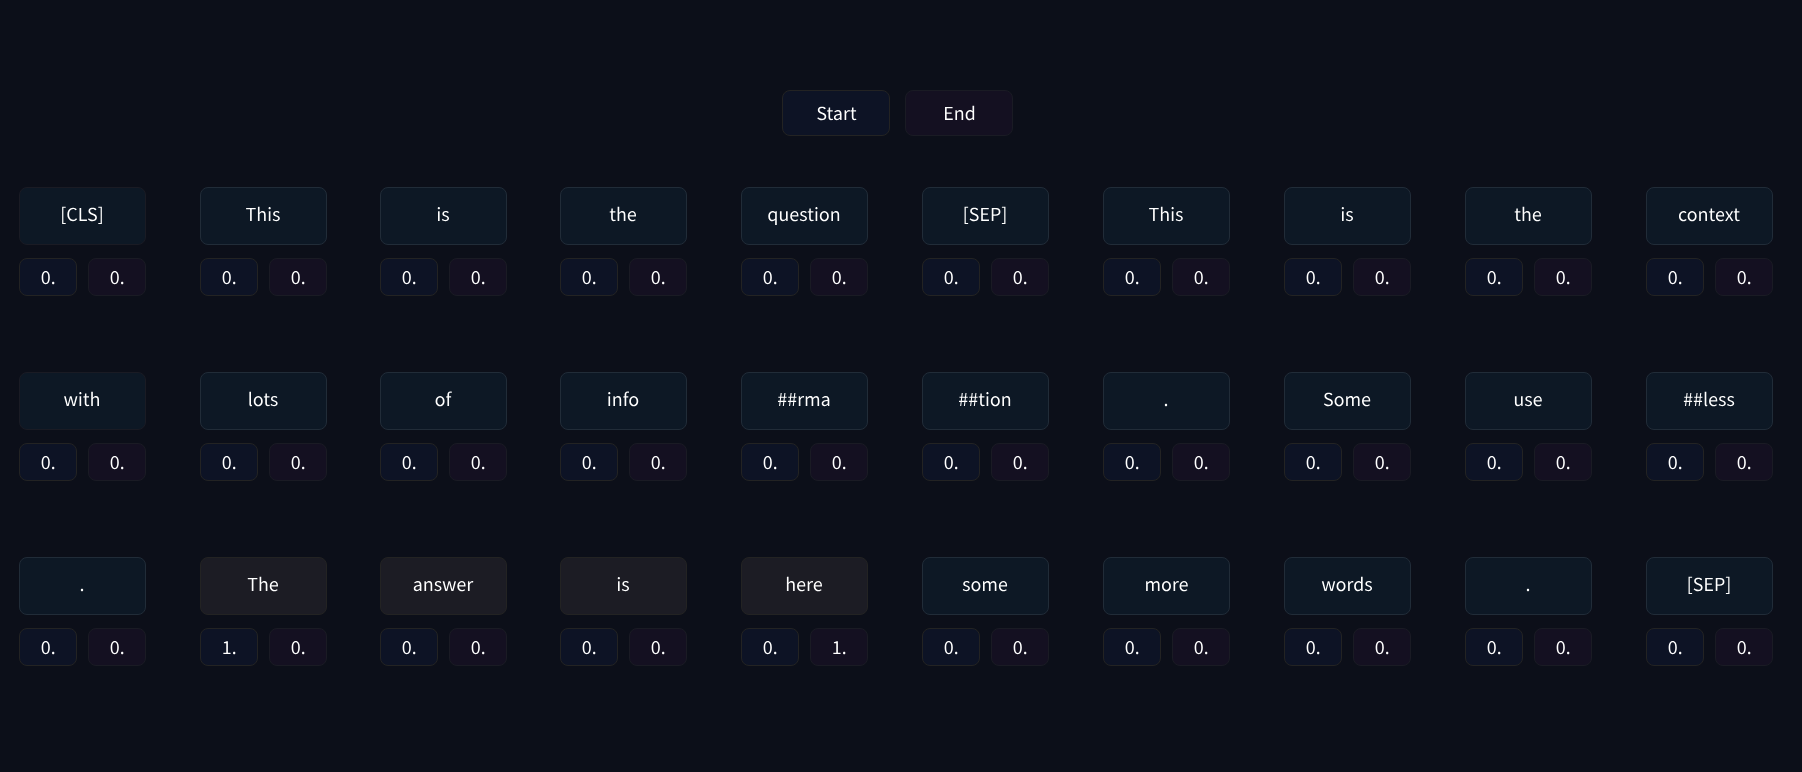

В данном случае контекст не слишком длинный, но некоторые примеры в датасете имеют очень длинные контексты, которые превысят установленную нами максимальную длину (которая в данном случае равна 384).

Чтобы увидеть, как это работает на текущем примере, мы можем ограничить длину до 100 и использовать скользящее окно из 50 токенов. Используем:
* max_length (возьмем 100)
* truncation="only_second" для усечения контекста (который находится во второй позиции), когда вопрос с его контекстом слишком длинный
* stride для задания количества перекрывающихся токенов между двумя последовательными фрагментами (возьмем 50)
* return_overflowing_tokens=True, чтобы сообщить токенизатору, что нам нужны переполненные токены (overflowing tokens)

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building ' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is the

Как мы можем видеть, наш пример был разбит на четыре входа, каждый из которых содержит вопрос и часть контекста. Ответ на вопрос ("Bernadette Soubirous") появляется только в третьем и последнем входе, поэтому, работая с длинными контекстами таким образом, мы создадим несколько обучающих примеров, в которых ответ не будет включен в контекст. Для этих примеров метками будут start_position = end_position = 0 (таким образом мы предсказываем токен [CLS]). Мы также зададим эти метки в неудачном случае, когда ответ был усечен, так что у нас есть только его начало (или конец). Для примеров, где ответ полностью находится в контексте, метками будут индекс токена, с которого начинается ответ, и индекс токена, на котором ответ заканчивается.

Датасет предоставляет нам начальный символ ответа в контексте, а прибавив к нему длину ответа, мы можем найти конечный символ в контексте. Чтобы сопоставить их с индексами токенов, нам нужно использовать сопоставление смещений6. Мы можем настроить наш токенизатор на их возврат, передав return_offsets_mapping=True:

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

Как мы видим, нам возвращаются обычные идентификаторы входа, идентификаторы типов токенов и маска внимания, а также необходимое нам сопоставление смещений и дополнительный ключ overflow_to_sample_mapping. Соответствующее значение мы будем использовать при токенизации нескольких текстов одновременно (что мы и должны делать, чтобы извлечь выгоду из того, что наш токенизатор основан на Rust). Поскольку один образец может давать несколько признаков, он сопоставляет каждый признак с примером, из которого он произошел. Поскольку здесь мы токенизировали только один пример, мы получим список 0:

In [ ]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0]

Но если мы проведем токенизацию большего количества примеров, он станет эффективнее:

In [ ]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 19 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


Как мы видим, первые три примера (с индексами 2, 3 и 4 в обучающем наборе) дали по четыре признака, а последний пример (с индексом 5 в обучающем наборе) - 7 признаков.

Эта информация будет полезна для сопоставления каждого полученного признака с соответствующей меткой. Этими метками являются:

* (0, 0), если ответ не находится в соответствующей области контекста
* (start_position, end_position), если ответ находится в соответствующей области контекста, причем start_position - это индекс токена (во входных идентификаторах) в начале ответа, а end_position - индекс токена (во входных идентификаторах) в конце ответа

Чтобы определить, какой из этих случаев имеет место, и, если нужно, позиции токенов, мы сначала находим индексы, с которых начинается и заканчивается контекст во входных идентификаторах. Для этого мы могли бы использовать идентификаторы типов токенов, но поскольку они не обязательно существуют для всех моделей (например, DistilBERT их не требует), вместо этого мы воспользуемся методом sequence_ids() из BatchEncoding, который возвращает наш токенизатор.

Получив индексы токенов, мы смотрим на соответствующие смещения, которые представляют собой кортежи из двух целых чисел, обозначающих промежуток символов внутри исходного контекста. Таким образом, мы можем определить, начинается ли фрагмент контекста в этом признаке после ответа или заканчивается до начала ответа (в этом случае метка будет (0, 0)). Если это не так, мы зацикливаемся, чтобы найти первый и последний токен ответа:

In [ ]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Найдём начало и конец контекста
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # Если ответ не полностью находится внутри контекста, меткой будет (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # В противном случае это начальная и конечная позиции токенов
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],
 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

Давайте посмотрим на несколько результатов, чтобы убедиться в правильности нашего подхода. Для первого признака мы находим (83, 85) в качестве меток, поэтому давайте сравним теоретический ответ с декодированным диапазоном лексем с 83 по 85 (включительно):

In [ ]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: the Main Building, labels give: the Main Building


Итак, это совпадение! Теперь проверим индекс 4, где мы установили метки на (0, 0), что означает, что ответ не находится в фрагменте контекста этого признака:

In [ ]:
idx = 4
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: a Marian place of prayer and reflection, decoded example: [CLS] What is the Grotto at Notre Dame? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building ' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grot [SEP]


Нет ответа в контексте.

Теперь, когда мы шаг за шагом разобрались с предварительной обработкой обучающих данных, мы можем сгруппировать их в функцию, которую будем применять ко всему датасету. Мы дополним каждый признак до максимальной длины, которую мы задали, поскольку большинство контекстов будут длинными (и соответствующие образцы будут разбиты на несколько признаков), поэтому применение динамического дополнения здесь не имеет реальной пользы:

In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Найдём начало и конец контекста
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # Если ответ не полностью находится внутри контекста, меткой будет (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # В противном случае это начальная и конечная позиции токенов
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Обратите внимание, что мы определили две константы для определения максимальной длины и длины скользящего окна, а также добавили немного очистки перед токенизацией: некоторые вопросы в датасете SQuAD имеют лишние пробелы в начале и конце, которые ничего не добавляют, поэтому мы удалили эти лишние пробелы.

Чтобы применить эту функцию ко всему обучающему набору, мы используем метод Dataset.map() с флагом batched=True. Это необходимо, так как мы изменяем длину датасета (поскольку один пример может давать несколько обучающих признаков):

In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

(87599, 88729)

Как мы видим, предварительная обработка добавила около 1 000 признаков. Теперь наш обучающий набор готов к использованию. Перейдем к предварительной обработке валидационного набора.

## Подготовка валидационных данных

Предварительная обработка валидационных данных будет немного проще, поскольку нам не нужно генерировать метки. Настоящей радостью будет интерпретация прогнозов модели в диапазонах исходного контекста. Для этого нам нужно хранить как сопоставления смещений, так и способ сопоставления каждого созданного признака с оригинальным примером, из которого он взят. Поскольку в исходном датасете есть столбец ID, мы будем использовать этот ID.

Нужно очистить сопоставления смещений. Они будут содержать смещения для вопроса и контекста, но на этапе постобработки у нас не будет возможности узнать, какая часть входных идентификаторов соответствует контексту, а какая - вопросу (метод sequence_ids(), который мы использовали, доступен только для выхода токенизатора). Поэтому мы установим смещения, соответствующие вопросу, в None:

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10822)

В данном случае мы добавили всего пару сотен примеров, поэтому контексты в валидационном датасете немного короче.

Теперь, когда мы предварительно обработали все данные, можно приступать к обучению.

## Fine-Tuning модели

### Постобработка

Модель выведет логиты для начальной и конечной позиций ответа во входных идентификаторах.

Чтобы ускорить процесс, мы также не будем оценивать все возможные пары (start_token, end_token), а только те, которые соответствуют наибольшим n_best логитам (при n_best=20). Так как мы пропустим softmax, эти оценки будут оценками логитов, и будут получены путем взятия суммы начального и конечного логитов (вместо произведения, по правилу \(\log(ab) = \log(a) + \log(b)\)).

Чтобы продемонстрировать все это, нам понадобятся некоторые прогнозы. Поскольку мы еще не обучили нашу модель, мы будем использовать модель по умолчанию для конвейера QA, чтобы сгенерировать несколько прогнозов на небольшой части набора для валидации. Мы можем использовать ту же функцию обработки, что и раньше; поскольку она опирается на глобальную константу tokenizer, нам просто нужно изменить этот объект на токенизатор модели, которую мы хотим временно использовать:

In [ ]:
small_eval_set = raw_datasets["validation"].select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Теперь, когда препроцессинг завершен, мы меняем токенизатор обратно на тот, который был выбран изначально:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Затем мы удаляем из нашего eval_set столбцы, которые не ожидает модель, создаем батч со всей этой небольшой валидацией и пропускаем его через модель.

In [ ]:
eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Поскольку Trainer будет возвращать нам прогнозы в виде массивов NumPy, мы берем начальный и конечный логиты и конвертируем их в этот формат:

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Теперь нам нужно найти спрогнозированный ответ для каждого примера в small_eval_set. Один пример может быть разбит на несколько признаков в eval_set, поэтому первым шагом будет сопоставление каждого примера в small_eval_set с соответствующими признаками в eval_set:

In [ ]:
example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

Имея это на руках, мы можем приступить к работе, итерируясь по всем примерам и, для каждого примера, по всем ассоциированным с ним признакам. Как мы уже говорили, мы рассмотрим оценки логитов для n_best начальных логитов и конечных логитов, исключая позиции, которые дают:

Ответ, который не вписывается в контекст
Ответ с отрицательной длиной
Слишком длинный ответ (мы ограничиваем возможности по max_answer_length=30).
После того как мы получили все возможные ответы для одного примера, мы просто выбираем тот, который имеет лучшую оценку логита:

In [ ]:
n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Пропускаем ответы, которые не полностью соответствуют контексту
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Пропускайте ответы, длина которых либо < 0, либо > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

Окончательный формат спрогнозированных ответов - это тот, который ожидает метрика, которую мы будем использовать. Как обычно, мы можем загрузить ее с помощью библиотеки Evaluate:

In [ ]:
metric = evaluate.load("squad")

Эта метрика ожидает прогнозируемые ответы в формате, который мы видели выше (список словарей с одним ключом для идентификатора примера и одним ключом для прогнозируемого текста), и теоретические ответы в формате ниже (список словарей с одним ключом для идентификатора примера и одним ключом для возможных ответов):

In [ ]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

Теперь мы можем убедиться, что получаем разумные результаты, посмотрев на первый элемент обоих списков:

In [ ]:
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}


Не так уж плохо! Теперь давайте посмотрим на оценку, которую дает нам метрика:

In [ ]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 83.0, 'f1': 88.25000000000004}

Теперь давайте поместим все, что мы только что сделали, в функцию compute_metrics(), которую мы будем использовать в Trainer. Обычно функция compute_metrics() получает только кортеж eval_preds с логитами и метками. Здесь нам понадобится немного больше, так как мы должны искать в датасете признаков смещения и в датасете примеров исходные контексты, поэтому мы не сможем использовать эту функцию для получения обычных результатов оценки во время обучения. Мы будем использовать ее только в конце обучения для проверки результатов.

Функция compute_metrics() группирует те же шаги, что и до этого, только добавляется небольшая проверка на случай, если мы не найдем ни одного правильного ответа (в этом случае мы прогнозируем пустую строку).

In [ ]:
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Итерируемся по всем признакам, ассоциированным с этим примером
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Пропускаем ответы, которые не полностью соответствуют контексту
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Пропускайте ответы, длина которых либо < 0, либо > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Выбираем ответ с лучшей оценкой
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 83.0, 'f1': 88.25000000000004}

Выглядит отлично! Теперь давайте используем это для дообучения нашей модели.

### Дообучение модели

Теперь мы готовы к обучению нашей модели. Давайте сначала создадим ее, используя класс AutoModelForQuestionAnswering, как и раньше:

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Как обычно, мы получаем предупреждение о том, что некоторые веса не используются (веса головы предварительного обучения), а другие инициализируются случайным образом (веса головы ответов на вопросы). Вы уже должны были привыкнуть к этому, но это означает, что модель еще не готова к использованию и нуждается в дообучении - хорошо, что мы сейчас этим займемся!

Можем определить наши TrainingArguments. Как мы уже говорили, когда определяли нашу функцию для вычисления метрики, мы не сможем сделать обычный цикл оценки из-за сигнатуры функции compute_metrics(). Мы могли бы написать собственный подкласс Trainer для этого, но это слишком длинно для данного раздела. Вместо этого мы будем оценивать модель только в конце обучения, а как проводить регулярную оценку, покажем ниже в разделе "Пользовательский цикл обучения".

In [ ]:
args = TrainingArguments(
    "bert-finetuned-squad",
    # evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)

Наконец, мы просто передаем все в класс Trainer и запускаем обучение:

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

<ipython-input-41-705e4356bf8d>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nesterenkoms2001 (nesterenkoms2001-digitaltech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,2.584100
1000,1.633800
1500,1.468400
2000,1.371500
2500,1.341300
3000,1.310500
3500,1.246000
4000,1.204500
4500,1.142600
5000,1.171800


TrainOutput(global_step=33276, training_loss=0.8307261640656695, metrics={'train_runtime': 6233.5755, 'train_samples_per_second': 42.702, 'train_steps_per_second': 5.338, 'total_flos': 5.216534983896422e+16, 'train_loss': 0.8307261640656695, 'epoch': 3.0})

Когда обучение завершено, мы можем наконец оценить нашу модель (и помолиться, что не потратили все это время вычислений впустую). Метод predict() функции Trainer вернет кортеж, где первыми элементами будут предсказания модели (здесь пара с начальным и конечным логитами). Мы отправляем его в нашу функцию compute_metrics():

In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 81.41911069063387, 'f1': 88.78188409803708}

Отлично! Для сравнения, базовые показатели, указанные в статье BERT для этой модели, составляют 80,8 и 88,5, так что мы как раз там, где должны быть.

Наконец, мы используем метод push_to_hub(), чтобы убедиться, что мы загрузили последнюю версию модели:

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Maksim01gh/bert-finetuned-squad/commit/0fc95b475b1a0cea2a66b443a39814a6d2805e57', commit_message='Training complete', commit_description='', oid='0fc95b475b1a0cea2a66b443a39814a6d2805e57', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maksim01gh/bert-finetuned-squad', endpoint='https://huggingface.co', repo_type='model', repo_id='Maksim01gh/bert-finetuned-squad'), pr_revision=None, pr_num=None)

Это возвращает URL только что выполненного коммита.

Trainer также создает черновик карточки модели со всеми результатами оценки и загружает ее.

### Цикл обучения

Сначала нам нужно создать DataLoaderы из наших датасетов. Мы установим формат этих датасетов в "torch" и удалим столбцы в наборе валидации, которые не используются моделью. Затем мы можем использовать default_data_collator, предоставляемый Transformers, в качестве collate_fn и перемешаем обучающий набор, но не набор для валидации:

In [ ]:
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

Затем мы реинстанцируем нашу модель, чтобы убедиться, что мы не продолжаем дообучение, а снова начинаем с предварительно обученной модели BERT:

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Тогда нам понадобится оптимизатор. Как обычно, мы используем классический AdamW, который похож на Adam, но с исправлением в способе применения затухания веса:

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
# accelerator = Accelerator(fp16=True)
accelerator = Accelerator(mixed_precision="fp16")
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Мы можем использовать длину train_dataloader для вычисления количества шагов обучения только после того, как она пройдет через метод accelerator.prepare(). Мы используем тот же линейный график, что и в предыдущих разделах:

In [ ]:
num_train_epochs = 2
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Чтобы отправить нашу модель на Hub, нам нужно создать объект Repository в рабочей папке. Сначала войдите в Hub Hugging Face, если вы еще не вошли в него. Мы определим имя розитория по идентификатору модели, который мы хотим присвоить нашей модели (не стесняйтесь заменить repo_name на свое усмотрение; оно просто должно содержать ваше имя пользователя, что и делает функция get_full_repo_name()):

In [ ]:
model_name = "bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'Maksim01gh/bert-finetuned-squad-accelerate'

Код ниже вызовет ошибку "Repo not found". В сообществе HuggingFace найдено следующее решение проблемы:
* Перейдите к последней строке ошибки и найдите, какой репозиторий не найден.
* Перейдите на страницу [Hugging Face - The AI community building the future](https://huggingface.co/new), чтобы создать репозиторий, который отсутствует.
* Запустить код снова

In [ ]:
output_dir = "bert-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/Maksim01gh/bert-finetuned-squad-accelerate into local empty directory.


# Цикл обучения

Теперь мы готовы написать полный цикл обучения. После определения прогресс-бара, чтобы следить за ходом обучения, цикл состоит из трех частей:

Собственно обучение, которое представляет собой классическую итерацию по train_dataloader, прямой проход по модели, затем обратный проход и шаг оптимизатора.
Оценка, в которой мы собираем все значения для start_logits и end_logits перед преобразованием их в массивы NumPy. После завершения цикла оценки мы объединяем все результаты. Обратите внимание, что нам нужно произвести усечение, потому что Accelerator может добавить несколько примеров в конце, чтобы убедиться, что у нас одинаковое количество примеров в каждом процессе.
Сохранение и загрузка, где мы сначала сохраняем модель и токенизатор, а затем вызываем repo.push_to_hub(). Как и раньше, мы используем аргумент blocking=False, чтобы указать библиотеке 🤗 Hub на асинхронный процесс push. Таким образом, обучение продолжается нормально, а эта (длинная) инструкция выполняется в фоновом режиме.
Вот полный код цикла обучения:

In [ ]:
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Обучение
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Оценка
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Сохранение и загрузка
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/22184 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

epoch 0: {'exact_match': 80.99337748344371, 'f1': 88.49970619576237}
Evaluation!


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

epoch 1: {'exact_match': 80.89877010406812, 'f1': 88.52852171283072}


# Использование дообученной модели

Чтобы использовать ее локально в pipeline, нужно просто указать идентификатор модели:

In [ ]:
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""

Device set to use cuda:0


In [ ]:
# Список вопросов
questions = [
    "Which deep learning libraries back Transformers?",
    "How many popular deep learning libraries support Transformers?",
    "Can you switch between libraries after training a model?",
    "Name a library that integrates with Transformers other than PyTorch.",
    "What is the main advantage of Transformers' library integration?"
]

# Запуск модели для каждого вопроса
for question in questions:
    result = question_answerer(question=question, context=context)
    print(f"Вопрос: {question}")
    print(f"Ответ: {result['answer']} (score: {result['score']:.4f})\n")

Вопрос: Which deep learning libraries back Transformers?
Ответ: Jax, PyTorch and TensorFlow (score: 0.9982)

Вопрос: How many popular deep learning libraries support Transformers?
Ответ: three (score: 0.9982)

Вопрос: Can you switch between libraries after training a model?
Ответ: It's straightforward (score: 0.2549)

Вопрос: Name a library that integrates with Transformers other than PyTorch.
Ответ: TensorFlow (score: 0.9776)

Вопрос: What is the main advantage of Transformers' library integration?
Ответ: It's straightforward to train your models with one (score: 0.0449)



Отлично! Наша модель работает так же хорошо, как и модель по умолчанию для этого конвейера!